**Deep Learning Asignment 1:**

**Part 1: implemnting forward phase of a fully connected neural network**

In [1]:
import numpy as np
import torch

def initialize_parameters(layer_dims):
  seed_value = 42
  torch.manual_seed(seed_value)

  WB_dict = {}
  for i in range(1, len(layer_dims)):
    w_i = torch.randn((layer_dims[i], layer_dims[i-1]), dtype=torch.float64) / layer_dims[i]
    # number of rows of matrix w is the number of perceptrons in the layer
    b_i = torch.zeros((layer_dims[i], 1), dtype=torch.float64)
    WB_dict[f"W{i}"] = w_i
    WB_dict[f"B{i}"] = b_i

  return WB_dict



In [2]:
def linear_forward(A, W, b):
  mul_res = torch.matmul(W, A)
  Z = mul_res + b
  linear_cache = {"A": A, "W": W, "B": b}
  return Z, linear_cache


In [3]:
def softmax(Z):
  sum_res = torch.sum(torch.exp(Z), dim=0)
  softmax_probs = torch.exp(Z) / sum_res
  return softmax_probs, Z

In [4]:
def relu(Z):
  return torch.max(Z, torch.tensor(0.0)), Z

In [5]:
def linear_activation_forward(A_prev, W, B, activation):
  z, linear_cache = linear_forward(A_prev, W, B)

  if activation == "relu":
    act, cache = relu(z)
  elif activation == "softmax":
    act, cache = softmax(z)

  joint_dict = linear_cache
  joint_dict["Z"] = cache

  return act, joint_dict

In [6]:
def L_model_forward(X, parameters, use_batchnorm):
  cache_lst = []
  num_layers = len(parameters) // 2
  A = X

  for layer in range(1, num_layers):
    new_A, cache = linear_activation_forward(A, parameters[f"W{layer}"], parameters[f"B{layer}"], activation = "relu")
    cache_lst.append(cache)
    if use_batchnorm:
      A = apply_batchnorm(new_A)
    else:
      A = new_A

  AL, cache = linear_activation_forward(A, parameters[f"W{num_layers}"], parameters[f"B{num_layers}"], activation = "softmax")
  cache_lst.append(cache)

  return AL, cache_lst


In [26]:
import math
def compute_cost(AL, Y, parameters, lamda=0):
  num_samples = AL.shape[1]
  L2_regularization = 0
  # Calculate the negative log likelihood loss
  sum_res = torch.sum(Y * torch.log(AL + 0.001), dim=0)
  cost = -1 * torch.mean(sum_res).item()
  # convert params dict to params vec
  if lamda != 0:
    parameters = param_dict_2vec(parameters)
    L2_regularization = (lamda / (2*num_samples)) * (torch.sum(torch.square(parameters))).item()
  loss = cost + L2_regularization
  return loss



In [8]:
def param_dict_2vec(params_dict):
  c = 0
  for key in params_dict.keys():
      vec = torch.reshape(params_dict[key], (-1, 1))
      if c == 0:
        params_vec = vec
      else:
          params_vec = torch.cat((params_vec, vec))
      c += 1

  return params_vec

In [9]:
def apply_batchnorm(A):
  mean_value = torch.mean(A, dim=1, keepdim=True)
  std_value = torch.std(A, dim=1, keepdim=True)
  epsilon = 0.001
  z_norm = (A - mean_value) / (std_value + epsilon)
  return z_norm

**Part 2 : implemnting backward phase of a fully connected neural network**

In [10]:
def Linear_backward(dZ, cache, lamda=0):
  derative_dict = {}
  A = cache["A"].T
  W = cache["W"].T

  derative_dict["dx"] = torch.matmul(W, dZ)
  derative_dict["dw"] = torch.matmul(dZ, A) + lamda * cache["W"]
  derative_dict["db"] = torch.sum(dZ, dim=1, keepdim=True)

  return derative_dict




In [11]:
def relu_backward(dA, activation_cache):
  split_tensor = torch.where(activation_cache > 0, torch.tensor(1.0), torch.tensor(0.0))
  relu_backward = dA * split_tensor
  return relu_backward

In [12]:
def softmax_backward(dA, activation_cache):
  pass


In [13]:
def linear_activation_backward(dA, cache, activation="relu", lamda=0):
  z = cache["Z"]
  dz = relu_backward(dA, z)
  d_dict = Linear_backward(dz, cache, lamda)
  return d_dict




In [14]:
def L_model_backward(AL, Y, caches, lamda=0):
  num_layers = len(caches)
  grad_dict = {}
  num_labels = AL.shape[0]
  num_samples = AL.shape[1]

  # Compute the gradient
  gradient = AL - Y

  d_linear_sf = Linear_backward(gradient, caches[-1], lamda)
  grad_dict[f"dA{num_layers}"] = d_linear_sf["dx"]
  grad_dict[f"dW{num_layers}"] = d_linear_sf["dw"]
  grad_dict[f"dB{num_layers}"] = d_linear_sf["db"]


  # lr is the number of linear-relu layers
  lr = num_layers -2
  dA = d_linear_sf["dx"]


  for i in range(lr, -1, -1):
    d_layer = linear_activation_backward(dA, caches[i], activation="relu", lamda=lamda)
    grad_dict[f"dA{i+1}"] = d_layer["dx"]
    grad_dict[f"dW{i+1}"] = d_layer["dw"]
    grad_dict[f"dB{i+1}"] = d_layer["db"]
    dA = d_layer["dx"]


  for k in grad_dict.keys():
    grad_dict[k] = grad_dict[k] / num_samples

  return  grad_dict






In [15]:
def Update_parameters(parameters, grads, learning_rate):
  # up updated parameters
  up = {}
  for k in parameters:
    up[k] = torch.zeros_like(parameters[k])

  for k in parameters.keys():
    up[k] = parameters[k] - learning_rate * grads[f"d{k}"]

  return up

**Part 3: putting all togther making the model "implementing the train and predict phase"**

In [16]:
def L_layer_model(X, Y, layers_dims, learning_rate, num_iterations=100, batch_size=32, use_batchnorm=False, lamda=0):

    costs_train,costs_valid, info = [],[],[]

    # Divide into train (80% of train set) and validation(20% of the train set)
    train_size = int(X.shape[1] * 0.8)
    seed_value = 42
    torch.manual_seed(seed_value)
    shuffled_indices = torch.randperm(X.shape[1])
    indices_train = shuffled_indices[:train_size]
    indices_valid = shuffled_indices[train_size:]
    X_train,X_valid = X[:, indices_train],X[:, indices_valid]
    Y_train,Y_valid = Y[:, indices_train], Y[:, indices_valid]

    # initialize the parameters
    parameters = initialize_parameters(layers_dims)
    batch_count = 1
    epoch_num=0

    for epoch in range(num_iterations):
        for ind, i in enumerate(range(0, X_train.shape[1], batch_size)):

            batch_end = i + min(batch_size, X_train.shape[1] - i) # Index to the end of the batch
            X_train_batch = X_train[:, i:batch_end]
            Y_train_batch = Y_train[:, i:batch_end]
            AL, caches = L_model_forward(X_train_batch, parameters, use_batchnorm) #run forward propagation
            grads = L_model_backward(AL, Y_train_batch, caches, lamda)#run backward propagation
            parameters = Update_parameters(parameters, grads, learning_rate) # update parameters

            if batch_count % 100 == 0:
                train_cost = compute_cost(AL, Y_train_batch, parameters, lamda)
                costs_train.append(train_cost)


                AL_valid, caches_valid = L_model_forward(X_valid, parameters, use_batchnorm)
                valid_cost= compute_cost(AL_valid, Y_valid, parameters, lamda)
                costs_valid.append(valid_cost)
                print(f"The cost on trianing step number: {batch_count}, the training loss: {round(train_cost,5)}")

                # check improvement threshold
                if len(costs_valid) > 1 and np.abs(valid_cost - costs_valid[-2]) < 0.0001:
                    train_accuracy = Predict(X_train, Y_train, parameters,use_batchnorm)
                    validation_accuracy = Predict(X_valid, Y_valid, parameters,use_batchnorm)
                    print("Parameter Network:"+'\n'+str(parameters))
                    print(f'Epoch Num: {epoch+1}')
                    print(f'Num Iteration: {batch_count}')
                    print(f'Costs Train: {round(train_cost, 5)}')
                    print(f'Costs Validation: {round(valid_cost, 5)}')
                    print(f'Train Accuracy: {round(train_accuracy, 5)}')
                    print(f'Validation Accuracy: {round(validation_accuracy, 5)}')
                    info.append([epoch,batch_count,train_accuracy,validation_accuracy, costs_train, costs_valid])
                    return parameters,costs_train, info
            batch_count += 1

    # if finished all epochs then: calculate train & validation accuracy and finish.
    train_accuracy = Predict(X_train, Y_train, parameters,use_batchnorm)
    validation_accuracy = Predict(X_valid, Y_valid, parameters,use_batchnorm)
    print("Parameter Network:"+'\n'+str(parameters))
    print(f'Epoch Num: {epoch+1}')
    print(f'Num Iteration: {batch_count}')
    print(f'Costs Train: {round(train_cost, 5)}')
    print(f'Costs Validation: {round(valid_cost, 5)}')
    print(f'Train Accuracy: {round(train_accuracy, 5)}')
    print(f'Validation Accuracy: {round(validation_accuracy, 5)}')
    info.append([epoch,batch_count,train_accuracy,validation_accuracy, costs_train, costs_valid])
    return parameters,costs_train, info

In [17]:
def Predict(X, Y, parameters, use_batchnorm=False):
  AL, _ = L_model_forward(X, parameters, use_batchnorm=use_batchnorm)
  predicted_labels = torch.argmax(AL, dim=0)
  num_samples = X.shape[1]
  true_labeld = 0
  for i in range(num_samples):
    y = Y[:, i]
    if y[predicted_labels[i]] == 1:
      true_labeld += 1
    else:
      continue

  return true_labeld / num_samples




**Importing the mnist dataset and preforming prepocessing on the data**

In [18]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from sklearn.model_selection import train_test_split

(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()

# Preprocess the data and flatten the images
train_images, test_images = train_images / 255.0, test_images / 255.0
train_images = train_images.reshape((train_images.shape[0], 28 * 28))
test_images = test_images.reshape((test_images.shape[0], 28 * 28))

# One-Hot Encode Labels
train_labels = tf.keras.utils.to_categorical(train_labels, num_classes=10)
test_labels = tf.keras.utils.to_categorical(test_labels, num_classes=10)

# Split the training data into training and validation sets
train_images, val_images, train_labels, val_labels = train_test_split(
    train_images, train_labels, test_size=0.2, random_state=42
)
train_images_tensor = torch.tensor(train_images.T, dtype=torch.float64)
train_labels_tensor = torch.tensor(train_labels.T, dtype=torch.float64)
val_images_tensor = torch.tensor(val_images.T, dtype=torch.float64)
val_labels_tensor = torch.tensor(val_labels.T, dtype=torch.float64)
test_images_tensor = torch.tensor(test_images.T, dtype=torch.float64)
test_labels_tensor = torch.tensor(test_labels.T, dtype=torch.float64)

11490434/11490434 [==============================] - 0s 0us/step


**Part 4: running the model without using batch normalization**

The cost on trianing step number: 100, the training loss: 2.29117
The cost on trianing step number: 200, the training loss: 2.28701
The cost on trianing step number: 300, the training loss: 2.28914
The cost on trianing step number: 400, the training loss: 2.29671
The cost on trianing step number: 500, the training loss: 2.2723
The cost on trianing step number: 600, the training loss: 2.28396
The cost on trianing step number: 700, the training loss: 2.29099
The cost on trianing step number: 800, the training loss: 2.29071
The cost on trianing step number: 900, the training loss: 2.27926
The cost on trianing step number: 1000, the training loss: 2.2743
The cost on trianing step number: 1100, the training loss: 2.28076
The cost on trianing step number: 1200, the training loss: 2.26597
The cost on trianing step number: 1300, the training loss: 2.29655
The cost on trianing step number: 1400, the training loss: 2.28627
The cost on trianing step number: 1500, the training loss: 2.25232
The co

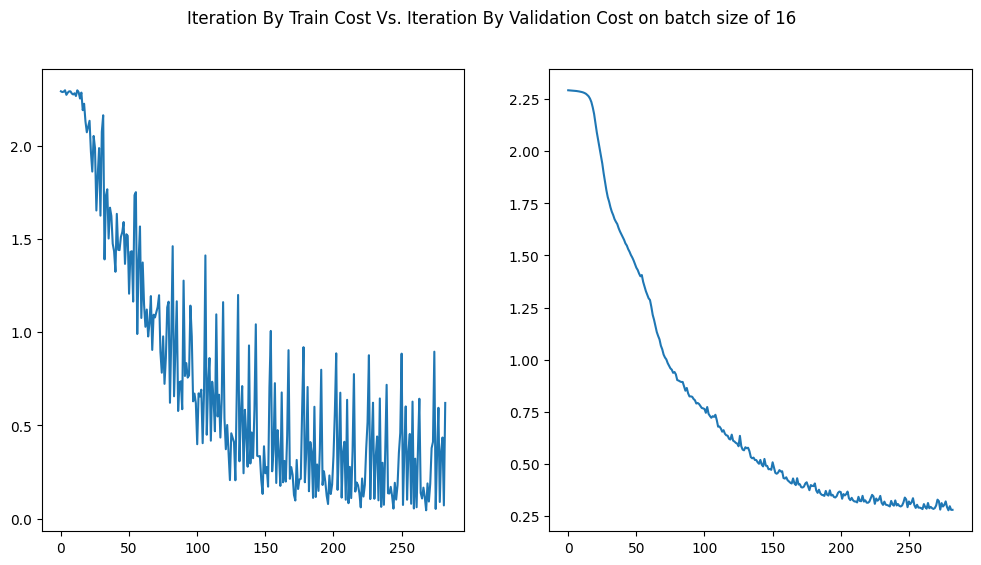

The cost on trianing step number: 100, the training loss: 2.29053
The cost on trianing step number: 200, the training loss: 2.29341
The cost on trianing step number: 300, the training loss: 2.28889
The cost on trianing step number: 400, the training loss: 2.28952
The cost on trianing step number: 500, the training loss: 2.28626
The cost on trianing step number: 600, the training loss: 2.29307
The cost on trianing step number: 700, the training loss: 2.28921
The cost on trianing step number: 800, the training loss: 2.29247
The cost on trianing step number: 900, the training loss: 2.2894
The cost on trianing step number: 1000, the training loss: 2.27907
The cost on trianing step number: 1100, the training loss: 2.27467
The cost on trianing step number: 1200, the training loss: 2.28327
The cost on trianing step number: 1300, the training loss: 2.2799
The cost on trianing step number: 1400, the training loss: 2.28961
The cost on trianing step number: 1500, the training loss: 2.25914
The co

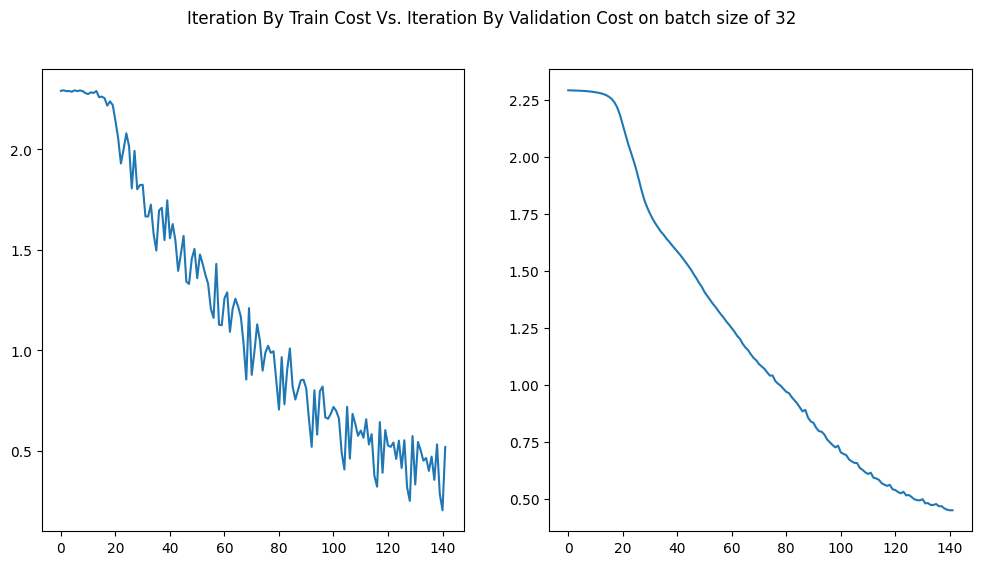

The cost on trianing step number: 100, the training loss: 2.29361
The cost on trianing step number: 200, the training loss: 2.29341
The cost on trianing step number: 300, the training loss: 2.29407
The cost on trianing step number: 400, the training loss: 2.29053
The cost on trianing step number: 500, the training loss: 2.28921
The cost on trianing step number: 600, the training loss: 2.29128
The cost on trianing step number: 700, the training loss: 2.29607
The cost on trianing step number: 800, the training loss: 2.29385
The cost on trianing step number: 900, the training loss: 2.29175
The cost on trianing step number: 1000, the training loss: 2.28311
The cost on trianing step number: 1100, the training loss: 2.27912
The cost on trianing step number: 1200, the training loss: 2.2825
The cost on trianing step number: 1300, the training loss: 2.29414
The cost on trianing step number: 1400, the training loss: 2.28446
The cost on trianing step number: 1500, the training loss: 2.27707
The c

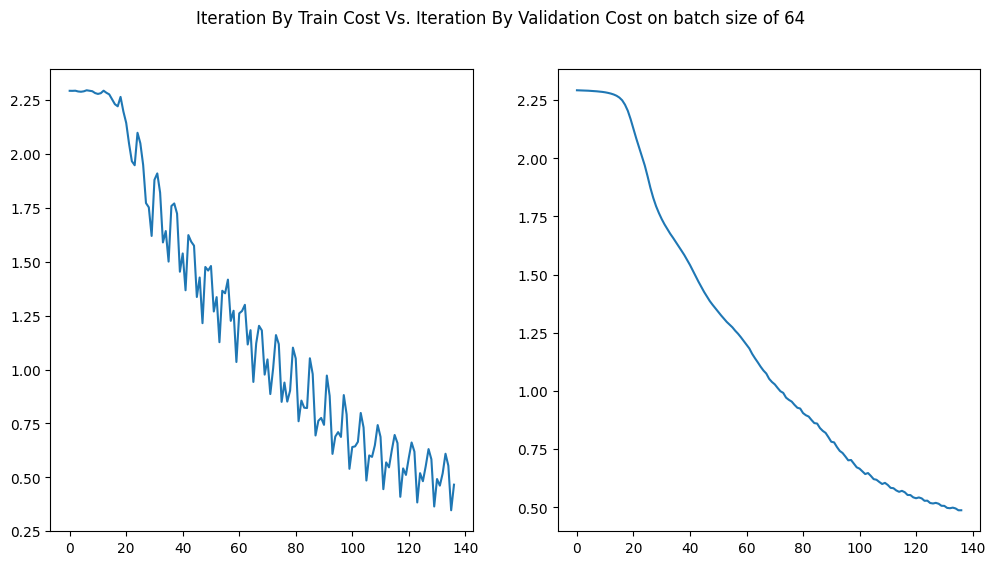

The cost on trianing step number: 100, the training loss: 2.2932
The cost on trianing step number: 200, the training loss: 2.29203
The cost on trianing step number: 300, the training loss: 2.29265
The cost on trianing step number: 400, the training loss: 2.29336
The cost on trianing step number: 500, the training loss: 2.29017
The cost on trianing step number: 600, the training loss: 2.29158
The cost on trianing step number: 700, the training loss: 2.29302
The cost on trianing step number: 800, the training loss: 2.28753
The cost on trianing step number: 900, the training loss: 2.28887
The cost on trianing step number: 1000, the training loss: 2.29128
The cost on trianing step number: 1100, the training loss: 2.283
The cost on trianing step number: 1200, the training loss: 2.28335
The cost on trianing step number: 1300, the training loss: 2.28674
The cost on trianing step number: 1400, the training loss: 2.27438
The cost on trianing step number: 1500, the training loss: 2.27076
The cos

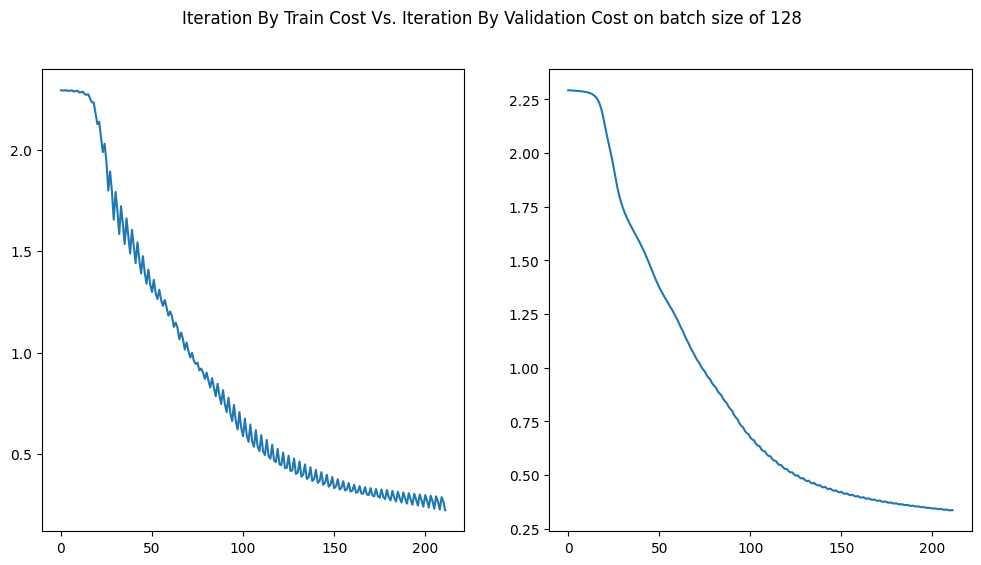

The cost on trianing step number: 100, the training loss: 2.29267
The cost on trianing step number: 200, the training loss: 2.29272
The cost on trianing step number: 300, the training loss: 2.2917
The cost on trianing step number: 400, the training loss: 2.29128
The cost on trianing step number: 500, the training loss: 2.2923
The cost on trianing step number: 600, the training loss: 2.2904
The cost on trianing step number: 700, the training loss: 2.28961
The cost on trianing step number: 800, the training loss: 2.29093
The cost on trianing step number: 900, the training loss: 2.28754
The cost on trianing step number: 1000, the training loss: 2.28627
The cost on trianing step number: 1100, the training loss: 2.28787
The cost on trianing step number: 1200, the training loss: 2.28199
The cost on trianing step number: 1300, the training loss: 2.27957
The cost on trianing step number: 1400, the training loss: 2.28034
The cost on trianing step number: 1500, the training loss: 2.26929
The cos

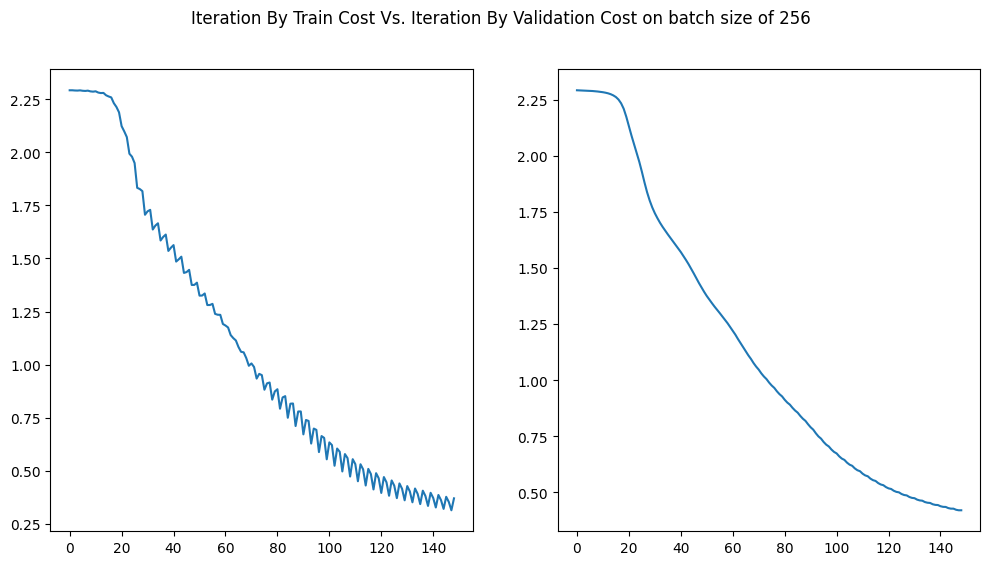

The cost on trianing step number: 100, the training loss: 2.29294
The cost on trianing step number: 200, the training loss: 2.29194
The cost on trianing step number: 300, the training loss: 2.29178
The cost on trianing step number: 400, the training loss: 2.29274
The cost on trianing step number: 500, the training loss: 2.29038
The cost on trianing step number: 600, the training loss: 2.29044
The cost on trianing step number: 700, the training loss: 2.29175
The cost on trianing step number: 800, the training loss: 2.288
The cost on trianing step number: 900, the training loss: 2.28736
The cost on trianing step number: 1000, the training loss: 2.28912
The cost on trianing step number: 1100, the training loss: 2.2838
The cost on trianing step number: 1200, the training loss: 2.28134
The cost on trianing step number: 1300, the training loss: 2.2832
The cost on trianing step number: 1400, the training loss: 2.27526
The cost on trianing step number: 1500, the training loss: 2.26741
The cost

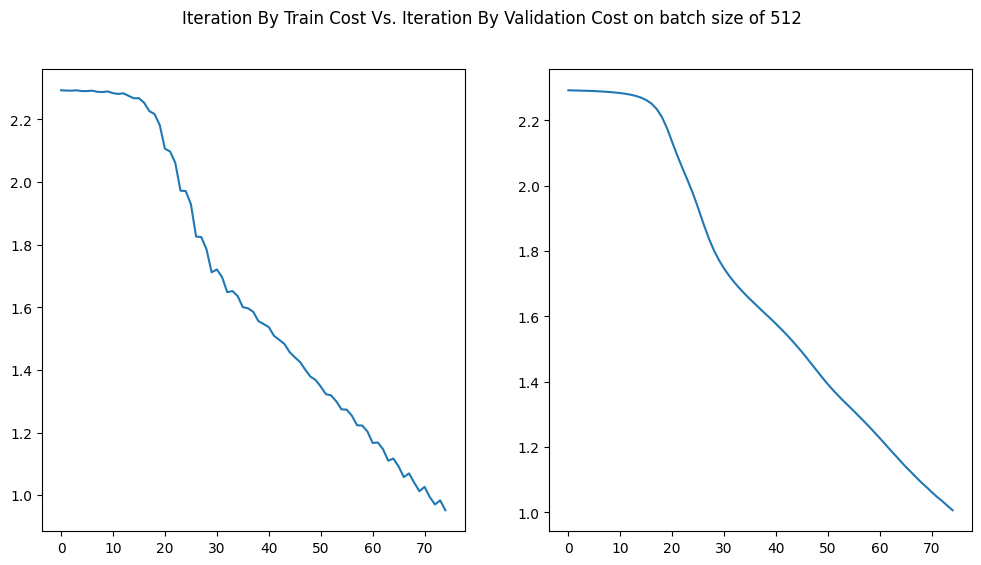

   Batch Size  Epoch Number  Iteration  Train Time in sec  Train Cost  \
0        16.0          11.0    28300.0          39.545093    0.619773   
1        32.0          11.0    14200.0          21.078546    0.520210   
2        64.0          22.0    13700.0          23.758513    0.465770   
3       128.0          70.0    21200.0          42.635906    0.223600   
4       256.0          99.0    14900.0          40.144472    0.369444   
5       512.0          99.0     7501.0          32.307549    0.951898   

   Train Accuracy  Validation Cost  Validation Accuracy  Test Accuracy  
0        0.933932         0.279818             0.919063         0.9212  
1        0.889245         0.451611             0.872292         0.8796  
2        0.872708         0.487337             0.859479         0.8638  
3        0.919714         0.336514             0.905417         0.9063  
4        0.891901         0.420726             0.881250         0.8831  
5        0.655547         1.006298             0.6

In [19]:
import matplotlib.pyplot as plt
import time
import pandas as pd

# Specify column names
columns = ['Batch Size', 'Epoch Number', 'Iteration', 'Train Time in sec', 'Train Cost', 'Train Accuracy', 'Validation Cost', 'Validation Accuracy', 'Test Accuracy']
# Create an empty DataFrame with specified column names
df = pd.DataFrame(columns=columns)

batches = [16,32,64,128,256,512]
layers_dims = [784,20,7,5,10]
learning_rate = 0.009
num_iterations = 100
use_batchnorm = False
lamda = 0
for batch in batches:
  start_time = time.time()
  wb, costs, info = L_layer_model(train_images_tensor, train_labels_tensor, layers_dims=layers_dims, learning_rate=learning_rate, num_iterations=num_iterations, batch_size=batch, use_batchnorm=use_batchnorm, lamda=lamda)
  end_time = time.time()
  elapsed_time = end_time - start_time
  train_costs = info[0][-2]
  valid_costs = info[0][-1]
  train_acc = info[0][2]
  valid_acc = info[0][3]
  test_acc = Predict(test_images_tensor, test_labels_tensor, wb, use_batchnorm=use_batchnorm)
  print(f'Test Accuracy: {round(test_acc, 5)}')
  df_row = [batch, info[0][0], info[0][1], elapsed_time, train_costs[-1], train_acc, valid_costs[-1], valid_acc, round(test_acc, 5)]
  df.loc[len(df)] = df_row
  # # create plots for report
  x1= [i for i in range(len(train_costs))]
  x2= [i for i in range(len(valid_costs))]
  fig, (ax1, ax2) = plt.subplots(1, 2)
  # fig = plt.figure()

  fig.set_size_inches(12, 6)
  fig.suptitle(f'Iteration By Train Cost Vs. Iteration By Validation Cost on batch size of {batch}')
  ax1.plot(x1, train_costs)
  ax2.plot(x2, valid_costs)
  plt.show()

print(df)








**Part 5 running the Model using batch norm**

The cost on trianing step number: 100, the training loss: 2.27632
The cost on trianing step number: 200, the training loss: 2.12018
The cost on trianing step number: 300, the training loss: 2.11593
The cost on trianing step number: 400, the training loss: 2.10603
The cost on trianing step number: 500, the training loss: 1.90472
The cost on trianing step number: 600, the training loss: 1.84464
The cost on trianing step number: 700, the training loss: 2.04173
The cost on trianing step number: 800, the training loss: 1.82066
The cost on trianing step number: 900, the training loss: 1.70066
The cost on trianing step number: 1000, the training loss: 1.76033
The cost on trianing step number: 1100, the training loss: 1.95256
The cost on trianing step number: 1200, the training loss: 1.59527
The cost on trianing step number: 1300, the training loss: 1.76054
The cost on trianing step number: 1400, the training loss: 1.61885
The cost on trianing step number: 1500, the training loss: 1.63576
The 

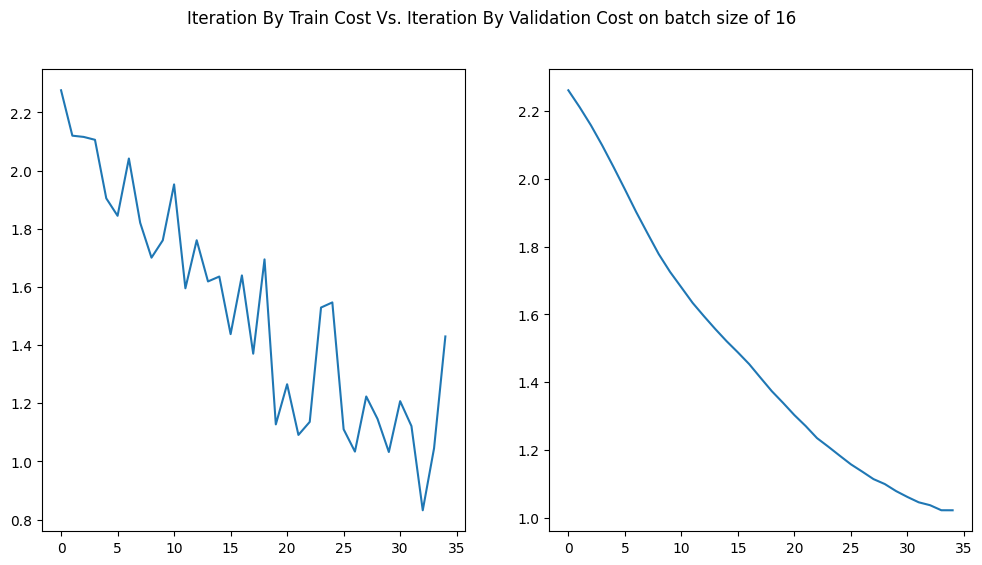

The cost on trianing step number: 100, the training loss: 2.25584
The cost on trianing step number: 200, the training loss: 2.2011
The cost on trianing step number: 300, the training loss: 2.11499
The cost on trianing step number: 400, the training loss: 2.07373
The cost on trianing step number: 500, the training loss: 2.01943
The cost on trianing step number: 600, the training loss: 1.99655
The cost on trianing step number: 700, the training loss: 1.8442
The cost on trianing step number: 800, the training loss: 1.80398
The cost on trianing step number: 900, the training loss: 1.75889
The cost on trianing step number: 1000, the training loss: 1.72077
The cost on trianing step number: 1100, the training loss: 1.53957
The cost on trianing step number: 1200, the training loss: 1.60322
The cost on trianing step number: 1300, the training loss: 1.63597
The cost on trianing step number: 1400, the training loss: 1.51536
The cost on trianing step number: 1500, the training loss: 1.49069
The co

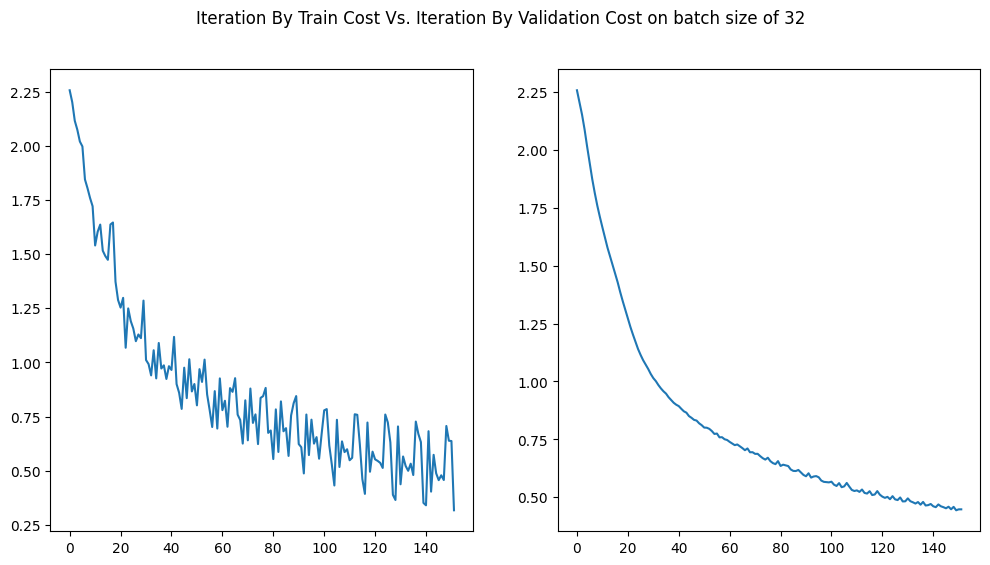

The cost on trianing step number: 100, the training loss: 2.25734
The cost on trianing step number: 200, the training loss: 2.20327
The cost on trianing step number: 300, the training loss: 2.13555
The cost on trianing step number: 400, the training loss: 2.06484
The cost on trianing step number: 500, the training loss: 2.04022
The cost on trianing step number: 600, the training loss: 1.97902
The cost on trianing step number: 700, the training loss: 1.83322
The cost on trianing step number: 800, the training loss: 1.85415
The cost on trianing step number: 900, the training loss: 1.7395
The cost on trianing step number: 1000, the training loss: 1.65237
The cost on trianing step number: 1100, the training loss: 1.72147
The cost on trianing step number: 1200, the training loss: 1.59479
The cost on trianing step number: 1300, the training loss: 1.59208
The cost on trianing step number: 1400, the training loss: 1.66988
The cost on trianing step number: 1500, the training loss: 1.5452
The co

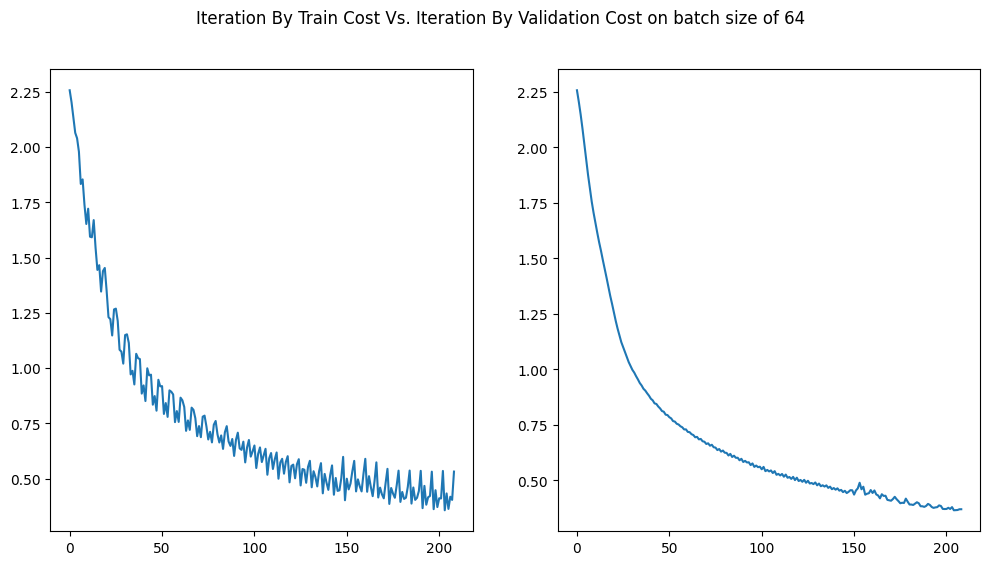

The cost on trianing step number: 100, the training loss: 2.26984
The cost on trianing step number: 200, the training loss: 2.1971
The cost on trianing step number: 300, the training loss: 2.16223
The cost on trianing step number: 400, the training loss: 2.09571
The cost on trianing step number: 500, the training loss: 1.95539
The cost on trianing step number: 600, the training loss: 1.93008
The cost on trianing step number: 700, the training loss: 1.86608
The cost on trianing step number: 800, the training loss: 1.73304
The cost on trianing step number: 900, the training loss: 1.70936
The cost on trianing step number: 1000, the training loss: 1.70694
The cost on trianing step number: 1100, the training loss: 1.59644
The cost on trianing step number: 1200, the training loss: 1.54418
The cost on trianing step number: 1300, the training loss: 1.58571
The cost on trianing step number: 1400, the training loss: 1.49612
The cost on trianing step number: 1500, the training loss: 1.42366
The c

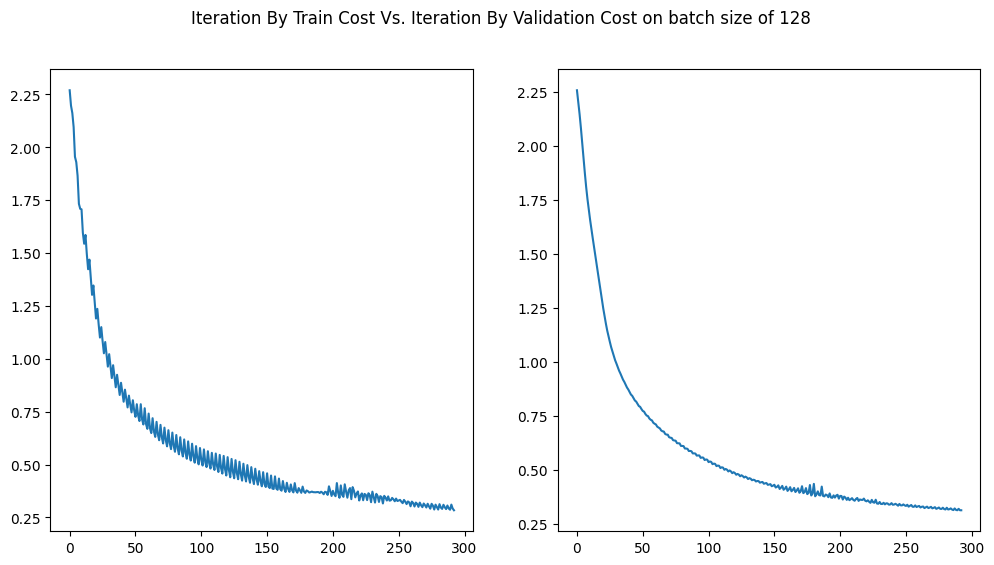

The cost on trianing step number: 100, the training loss: 2.27768
The cost on trianing step number: 200, the training loss: 2.20833
The cost on trianing step number: 300, the training loss: 2.15321
The cost on trianing step number: 400, the training loss: 2.06424
The cost on trianing step number: 500, the training loss: 2.0148
The cost on trianing step number: 600, the training loss: 1.92871
The cost on trianing step number: 700, the training loss: 1.82202
The cost on trianing step number: 800, the training loss: 1.81565
The cost on trianing step number: 900, the training loss: 1.72225
The cost on trianing step number: 1000, the training loss: 1.64491
The cost on trianing step number: 1100, the training loss: 1.67989
The cost on trianing step number: 1200, the training loss: 1.56544
The cost on trianing step number: 1300, the training loss: 1.52106
The cost on trianing step number: 1400, the training loss: 1.5589
The cost on trianing step number: 1500, the training loss: 1.4358
The cos

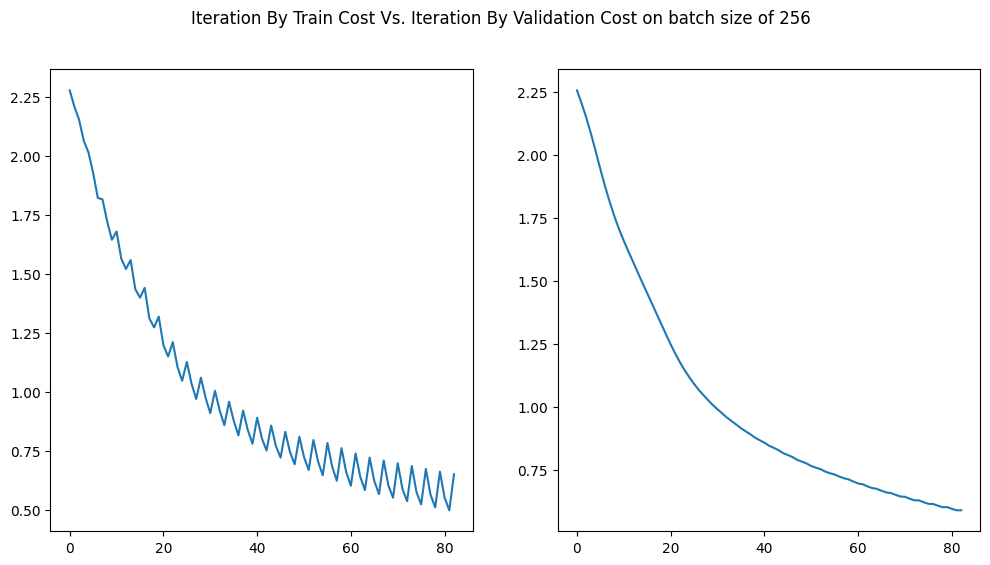

The cost on trianing step number: 100, the training loss: 2.25637
The cost on trianing step number: 200, the training loss: 2.20523
The cost on trianing step number: 300, the training loss: 2.14873
The cost on trianing step number: 400, the training loss: 2.09331
The cost on trianing step number: 500, the training loss: 1.99586
The cost on trianing step number: 600, the training loss: 1.9356
The cost on trianing step number: 700, the training loss: 1.89602
The cost on trianing step number: 800, the training loss: 1.77392
The cost on trianing step number: 900, the training loss: 1.73727
The cost on trianing step number: 1000, the training loss: 1.73894
The cost on trianing step number: 1100, the training loss: 1.61682
The cost on trianing step number: 1200, the training loss: 1.5814
The cost on trianing step number: 1300, the training loss: 1.61507
The cost on trianing step number: 1400, the training loss: 1.49438
The cost on trianing step number: 1500, the training loss: 1.44807
The co

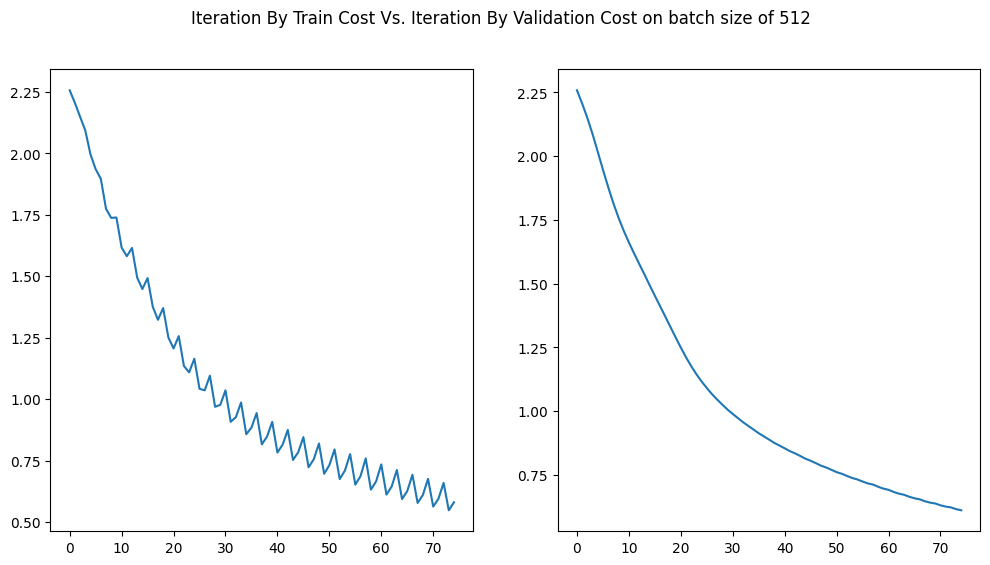

   Batch Size  Epoch Number  Iteration  Train Time in sec  Train Cost  \
0        16.0           1.0     3500.0           7.174161    1.429712   
1        32.0          12.0    15200.0          26.206354    0.317321   
2        64.0          34.0    20900.0          39.384307    0.531921   
3       128.0          97.0    29300.0          65.825940    0.283816   
4       256.0          55.0     8300.0          25.770843    0.651894   
5       512.0          99.0     7501.0          35.352157    0.580793   

   Train Accuracy  Validation Cost  Validation Accuracy  Test Accuracy  
0        0.631823         1.022430             0.637083         0.6316  
1        0.884349         0.447353             0.876354         0.8827  
2        0.905573         0.370209             0.894896         0.8987  
3        0.925625         0.313215             0.906875         0.9130  
4        0.858307         0.589825             0.854271         0.8569  
5        0.853958         0.611586             0.8

In [20]:
import matplotlib.pyplot as plt
import time
import pandas as pd

# Specify column names
columns = ['Batch Size', 'Epoch Number', 'Iteration', 'Train Time in sec', 'Train Cost', 'Train Accuracy', 'Validation Cost', 'Validation Accuracy', 'Test Accuracy']
# Create an empty DataFrame with specified column names
df = pd.DataFrame(columns=columns)

batches = [16,32,64,128,256,512]
layers_dims = [784,20,7,5,10]
learning_rate = 0.009
num_iterations = 100
use_batchnorm = True
lamda = 0
for batch in batches:
  start_time = time.time()
  wb, costs, info = L_layer_model(train_images_tensor, train_labels_tensor, layers_dims=layers_dims, learning_rate=learning_rate, num_iterations=num_iterations, batch_size=batch, use_batchnorm=use_batchnorm, lamda=lamda)
  end_time = time.time()
  elapsed_time = end_time - start_time
  train_costs = info[0][-2]
  valid_costs = info[0][-1]
  train_acc = info[0][2]
  valid_acc = info[0][3]
  test_acc = Predict(test_images_tensor, test_labels_tensor, wb, use_batchnorm=use_batchnorm)
  print(f'Test Accuracy: {round(test_acc, 5)}')
  df_row = [batch, info[0][0], info[0][1], elapsed_time, train_costs[-1], train_acc, valid_costs[-1], valid_acc, round(test_acc, 5)]
  df.loc[len(df)] = df_row
  # # create plots for report
  x1= [i for i in range(len(train_costs))]
  x2= [i for i in range(len(valid_costs))]
  fig, (ax1, ax2) = plt.subplots(1, 2)
  # fig = plt.figure()

  fig.set_size_inches(12, 6)
  fig.suptitle(f'Iteration By Train Cost Vs. Iteration By Validation Cost on batch size of {batch}')
  ax1.plot(x1, train_costs)
  ax2.plot(x2, valid_costs)
  plt.show()

print(df)

**Part 6: first we run the model using batch norm false and using l2 norm functionality with different values of lamda (we used lamda = 0.05 for best performance)**

The cost on trianing step number: 100, the training loss: 2.36082
The cost on trianing step number: 200, the training loss: 2.35626
The cost on trianing step number: 300, the training loss: 2.35804
The cost on trianing step number: 400, the training loss: 2.36526
The cost on trianing step number: 500, the training loss: 2.3404
The cost on trianing step number: 600, the training loss: 2.35181
The cost on trianing step number: 700, the training loss: 2.35841
The cost on trianing step number: 800, the training loss: 2.35786
The cost on trianing step number: 900, the training loss: 2.34628
The cost on trianing step number: 1000, the training loss: 2.34124
The cost on trianing step number: 1100, the training loss: 2.34834
The cost on trianing step number: 1200, the training loss: 2.33656
The cost on trianing step number: 1300, the training loss: 2.36247
The cost on trianing step number: 1400, the training loss: 2.3523
The cost on trianing step number: 1500, the training loss: 2.32803
The co

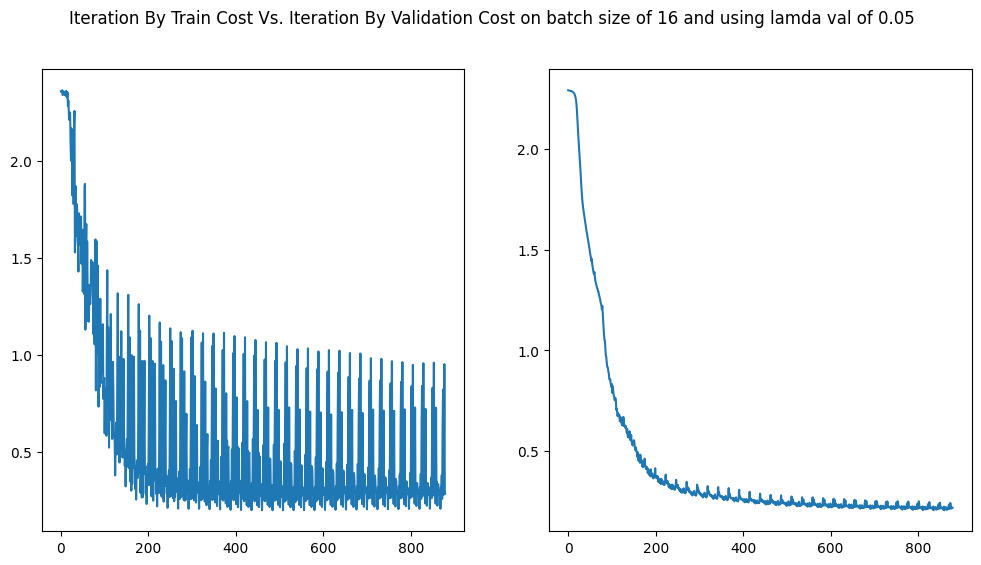

The cost on trianing step number: 100, the training loss: 2.32545
The cost on trianing step number: 200, the training loss: 2.32824
The cost on trianing step number: 300, the training loss: 2.32363
The cost on trianing step number: 400, the training loss: 2.32418
The cost on trianing step number: 500, the training loss: 2.32086
The cost on trianing step number: 600, the training loss: 2.32767
The cost on trianing step number: 700, the training loss: 2.32368
The cost on trianing step number: 800, the training loss: 2.32683
The cost on trianing step number: 900, the training loss: 2.32377
The cost on trianing step number: 1000, the training loss: 2.31375
The cost on trianing step number: 1100, the training loss: 2.30951
The cost on trianing step number: 1200, the training loss: 2.31807
The cost on trianing step number: 1300, the training loss: 2.31454
The cost on trianing step number: 1400, the training loss: 2.32463
The cost on trianing step number: 1500, the training loss: 2.29642
The 

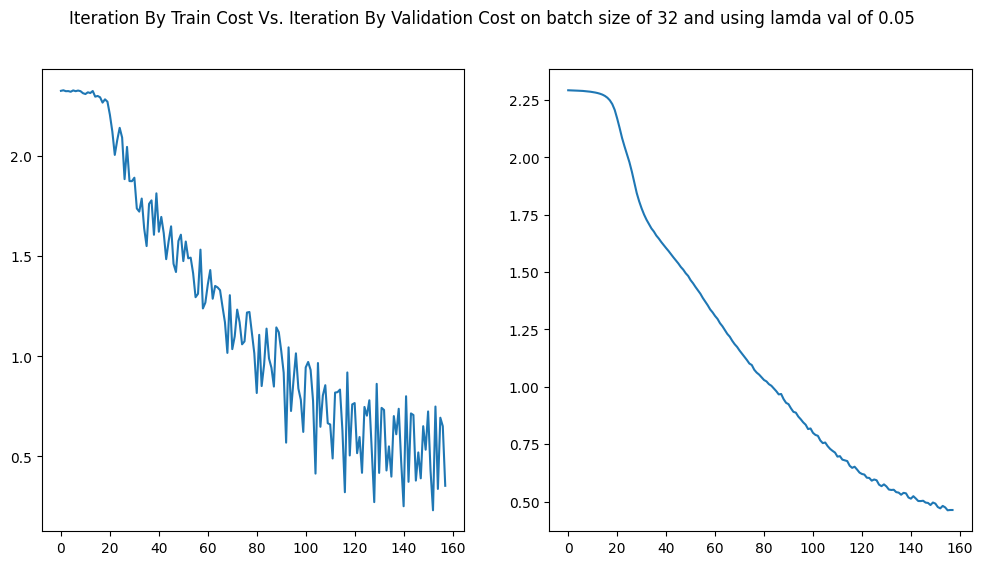

The cost on trianing step number: 100, the training loss: 2.31109
The cost on trianing step number: 200, the training loss: 2.31087
The cost on trianing step number: 300, the training loss: 2.31151
The cost on trianing step number: 400, the training loss: 2.30796
The cost on trianing step number: 500, the training loss: 2.30665
The cost on trianing step number: 600, the training loss: 2.30869
The cost on trianing step number: 700, the training loss: 2.31345
The cost on trianing step number: 800, the training loss: 2.31125
The cost on trianing step number: 900, the training loss: 2.30922
The cost on trianing step number: 1000, the training loss: 2.3007
The cost on trianing step number: 1100, the training loss: 2.29691
The cost on trianing step number: 1200, the training loss: 2.30032
The cost on trianing step number: 1300, the training loss: 2.31173
The cost on trianing step number: 1400, the training loss: 2.30261
The cost on trianing step number: 1500, the training loss: 2.29583
The c

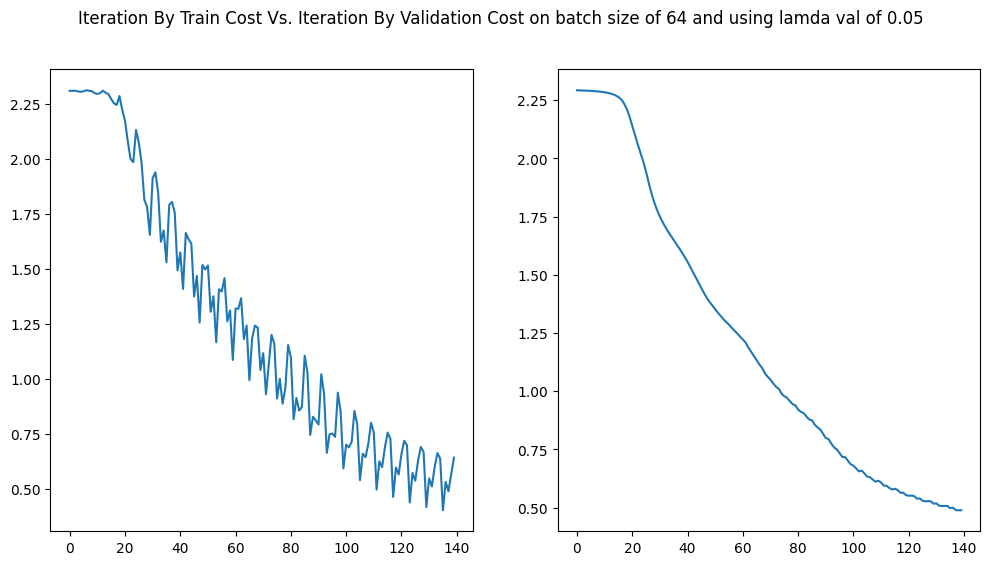

The cost on trianing step number: 100, the training loss: 2.30195
The cost on trianing step number: 200, the training loss: 2.30077
The cost on trianing step number: 300, the training loss: 2.30138
The cost on trianing step number: 400, the training loss: 2.30209
The cost on trianing step number: 500, the training loss: 2.2989
The cost on trianing step number: 600, the training loss: 2.30031
The cost on trianing step number: 700, the training loss: 2.30176
The cost on trianing step number: 800, the training loss: 2.29629
The cost on trianing step number: 900, the training loss: 2.29765
The cost on trianing step number: 1000, the training loss: 2.30006
The cost on trianing step number: 1100, the training loss: 2.29186
The cost on trianing step number: 1200, the training loss: 2.2923
The cost on trianing step number: 1300, the training loss: 2.2957
The cost on trianing step number: 1400, the training loss: 2.28358
The cost on trianing step number: 1500, the training loss: 2.28028
The cos

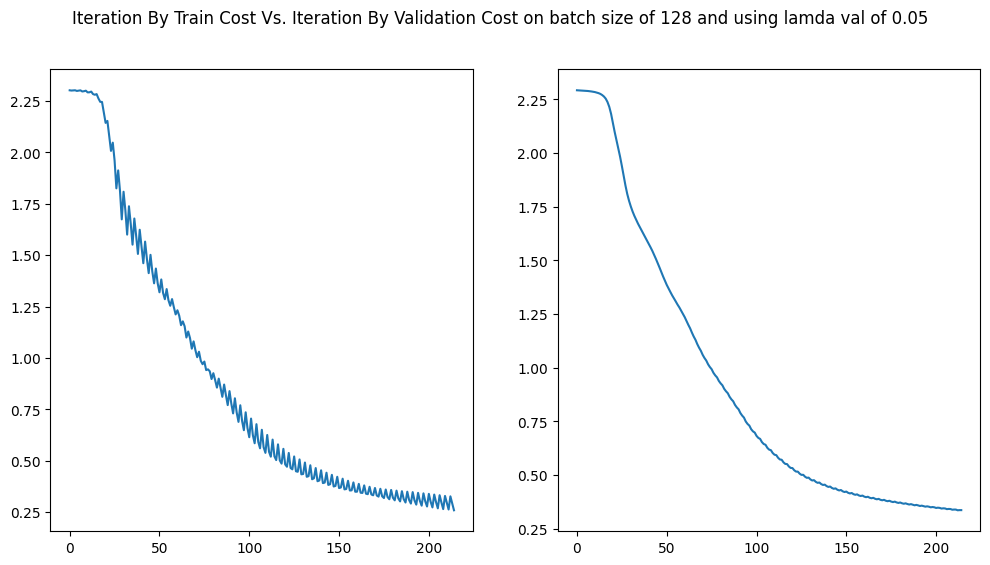

The cost on trianing step number: 100, the training loss: 2.29705
The cost on trianing step number: 200, the training loss: 2.29709
The cost on trianing step number: 300, the training loss: 2.29607
The cost on trianing step number: 400, the training loss: 2.29565
The cost on trianing step number: 500, the training loss: 2.29667
The cost on trianing step number: 600, the training loss: 2.29477
The cost on trianing step number: 700, the training loss: 2.294
The cost on trianing step number: 800, the training loss: 2.29532
The cost on trianing step number: 900, the training loss: 2.29194
The cost on trianing step number: 1000, the training loss: 2.29069
The cost on trianing step number: 1100, the training loss: 2.29232
The cost on trianing step number: 1200, the training loss: 2.28649
The cost on trianing step number: 1300, the training loss: 2.28412
The cost on trianing step number: 1400, the training loss: 2.28496
The cost on trianing step number: 1500, the training loss: 2.2741
The cos

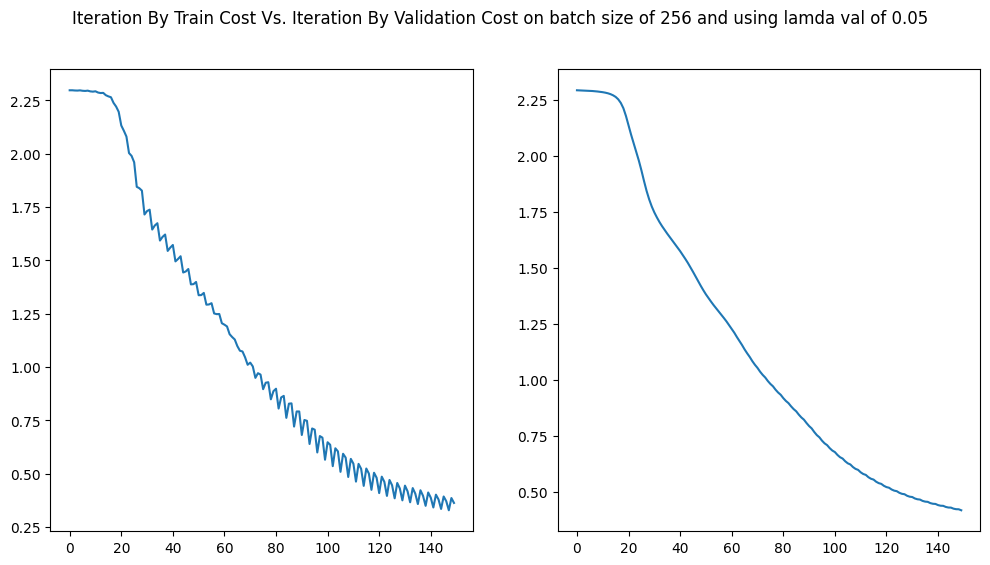

The cost on trianing step number: 100, the training loss: 2.29513
The cost on trianing step number: 200, the training loss: 2.29413
The cost on trianing step number: 300, the training loss: 2.29397
The cost on trianing step number: 400, the training loss: 2.29493
The cost on trianing step number: 500, the training loss: 2.29257
The cost on trianing step number: 600, the training loss: 2.29264
The cost on trianing step number: 700, the training loss: 2.29394
The cost on trianing step number: 800, the training loss: 2.2902
The cost on trianing step number: 900, the training loss: 2.28957
The cost on trianing step number: 1000, the training loss: 2.29133
The cost on trianing step number: 1100, the training loss: 2.28603
The cost on trianing step number: 1200, the training loss: 2.2836
The cost on trianing step number: 1300, the training loss: 2.28548
The cost on trianing step number: 1400, the training loss: 2.27759
The cost on trianing step number: 1500, the training loss: 2.26984
The co

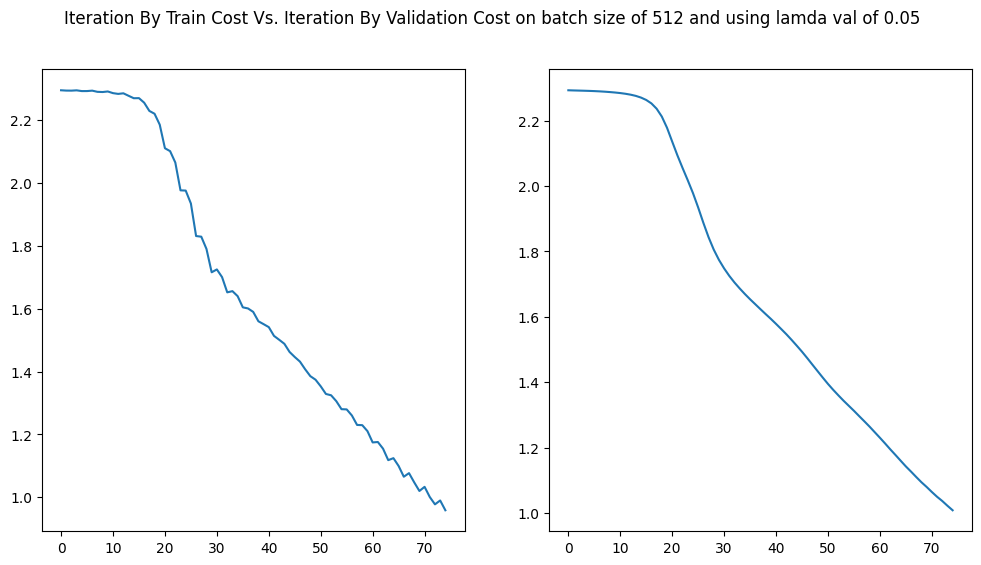

   Batch Size  Epoch Number  Iteration  Train Time in sec  Lamda  Train Cost  \
0        16.0          36.0    88000.0         111.886388   0.05    0.285722   
1        32.0          13.0    15800.0          23.392295   0.05    0.353336   
2        64.0          23.0    14000.0          23.426184   0.05    0.641019   
3       128.0          71.0    21500.0          42.839833   0.05    0.259270   
4       256.0          99.0    15001.0          41.572476   0.05    0.362785   
5       512.0          99.0     7501.0          31.583354   0.05    0.958572   

   Train Accuracy  Validation Cost  Validation Accuracy  Test Accuracy  
0        0.954844         0.218033             0.934792         0.9388  
1        0.885964         0.463098             0.872500         0.8793  
2        0.870078         0.488456             0.858125         0.8624  
3        0.919479         0.337129             0.907292         0.9069  
4        0.894714         0.417856             0.883021         0.8862  
5

In [21]:
# Specify column names
columns = ['Batch Size', 'Epoch Number', 'Iteration', 'Train Time in sec', 'Lamda', 'Train Cost', 'Train Accuracy', 'Validation Cost', 'Validation Accuracy', 'Test Accuracy']
# Create an empty DataFrame with specified column names
df = pd.DataFrame(columns=columns)

batches = [16,32,64,128,256,512]
layers_dims = [784,20,7,5,10]
learning_rate = 0.009
num_iterations = 100
use_batchnorm = False
lamda = [0.05]
for l in lamda:
  for batch in batches:
    start_time = time.time()
    wb, costs, info = L_layer_model(train_images_tensor, train_labels_tensor, layers_dims=layers_dims, learning_rate=learning_rate, num_iterations=num_iterations, batch_size=batch, use_batchnorm=use_batchnorm, lamda=l)
    end_time = time.time()
    elapsed_time = end_time - start_time
    train_costs = info[0][-2]
    valid_costs = info[0][-1]
    train_acc = info[0][2]
    valid_acc = info[0][3]
    test_acc = Predict(test_images_tensor, test_labels_tensor, wb, use_batchnorm=use_batchnorm)
    print(f'Test Accuracy: {round(test_acc, 5)}')
    df_row = [batch, info[0][0], info[0][1], elapsed_time, l, train_costs[-1], train_acc, valid_costs[-1], valid_acc, round(test_acc, 5)]
    df.loc[len(df)] = df_row
    # # create plots for report
    x1= [i for i in range(len(train_costs))]
    x2= [i for i in range(len(valid_costs))]
    fig, (ax1, ax2) = plt.subplots(1, 2)
    # fig = plt.figure()

    fig.set_size_inches(12, 6)
    fig.suptitle(f'Iteration By Train Cost Vs. Iteration By Validation Cost on batch size of {batch} and using lamda val of {l}')
    ax1.plot(x1, train_costs)
    ax2.plot(x2, valid_costs)
    plt.show()

print(df)

**now we run the model using batch norm True and using l2 norm functionality with different values of lamda (we used lamda = 0.05 for best performance)**

The cost on trianing step number: 100, the training loss: 2.34595
The cost on trianing step number: 200, the training loss: 2.19004
The cost on trianing step number: 300, the training loss: 2.18601
The cost on trianing step number: 400, the training loss: 2.17651
The cost on trianing step number: 500, the training loss: 1.97713
The cost on trianing step number: 600, the training loss: 1.91807
The cost on trianing step number: 700, the training loss: 2.11434
The cost on trianing step number: 800, the training loss: 1.89692
The cost on trianing step number: 900, the training loss: 1.77849
The cost on trianing step number: 1000, the training loss: 1.83847
The cost on trianing step number: 1100, the training loss: 2.03138
The cost on trianing step number: 1200, the training loss: 1.6774
The cost on trianing step number: 1300, the training loss: 1.84776
The cost on trianing step number: 1400, the training loss: 1.70136
The cost on trianing step number: 1500, the training loss: 1.72928
The c

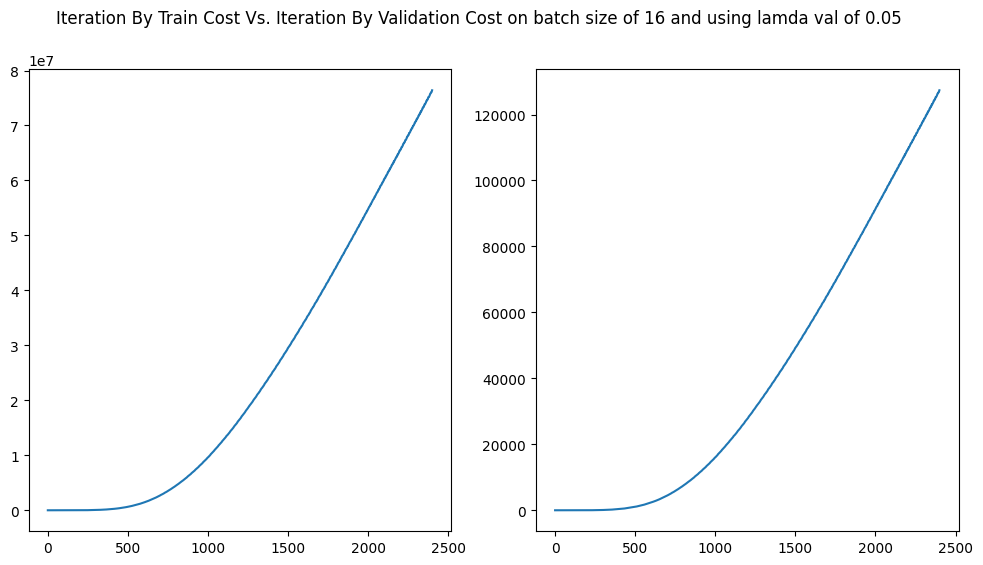

The cost on trianing step number: 100, the training loss: 2.29075
The cost on trianing step number: 200, the training loss: 2.2361
The cost on trianing step number: 300, the training loss: 2.15044
The cost on trianing step number: 400, the training loss: 2.10982
The cost on trianing step number: 500, the training loss: 2.05568
The cost on trianing step number: 600, the training loss: 2.03345
The cost on trianing step number: 700, the training loss: 1.88239
The cost on trianing step number: 800, the training loss: 1.84341
The cost on trianing step number: 900, the training loss: 1.79853
The cost on trianing step number: 1000, the training loss: 1.76102
The cost on trianing step number: 1100, the training loss: 1.58282
The cost on trianing step number: 1200, the training loss: 1.64625
The cost on trianing step number: 1300, the training loss: 1.68052
The cost on trianing step number: 1400, the training loss: 1.56037
The cost on trianing step number: 1500, the training loss: 1.53755
The c

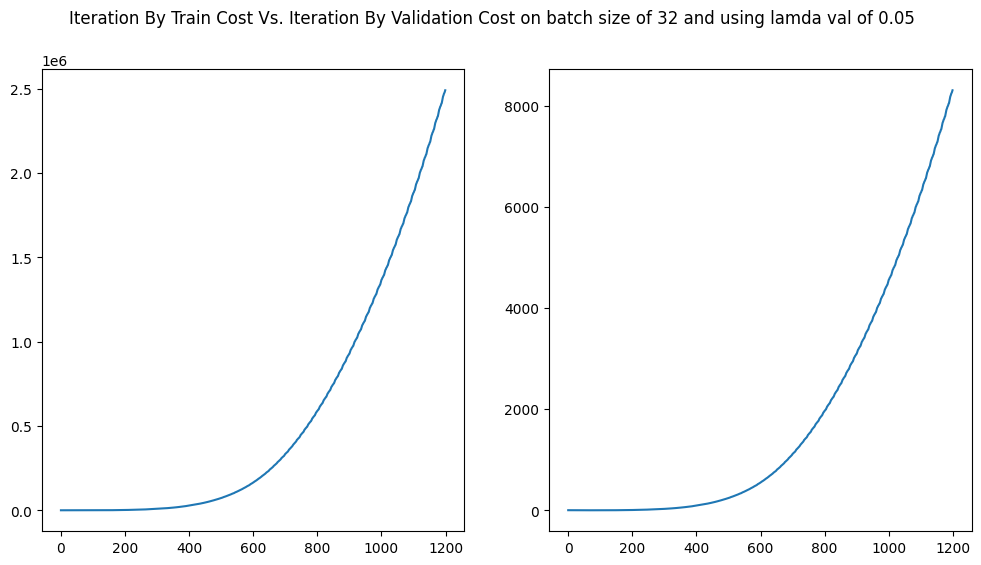

The cost on trianing step number: 100, the training loss: 2.27482
The cost on trianing step number: 200, the training loss: 2.22084
The cost on trianing step number: 300, the training loss: 2.15337
The cost on trianing step number: 400, the training loss: 2.08288
The cost on trianing step number: 500, the training loss: 2.05863
The cost on trianing step number: 600, the training loss: 1.99772
The cost on trianing step number: 700, the training loss: 1.8526
The cost on trianing step number: 800, the training loss: 1.87372
The cost on trianing step number: 900, the training loss: 1.75985
The cost on trianing step number: 1000, the training loss: 1.67312
The cost on trianing step number: 1100, the training loss: 1.74209
The cost on trianing step number: 1200, the training loss: 1.61603
The cost on trianing step number: 1300, the training loss: 1.61401
The cost on trianing step number: 1400, the training loss: 1.69277
The cost on trianing step number: 1500, the training loss: 1.56841
The c

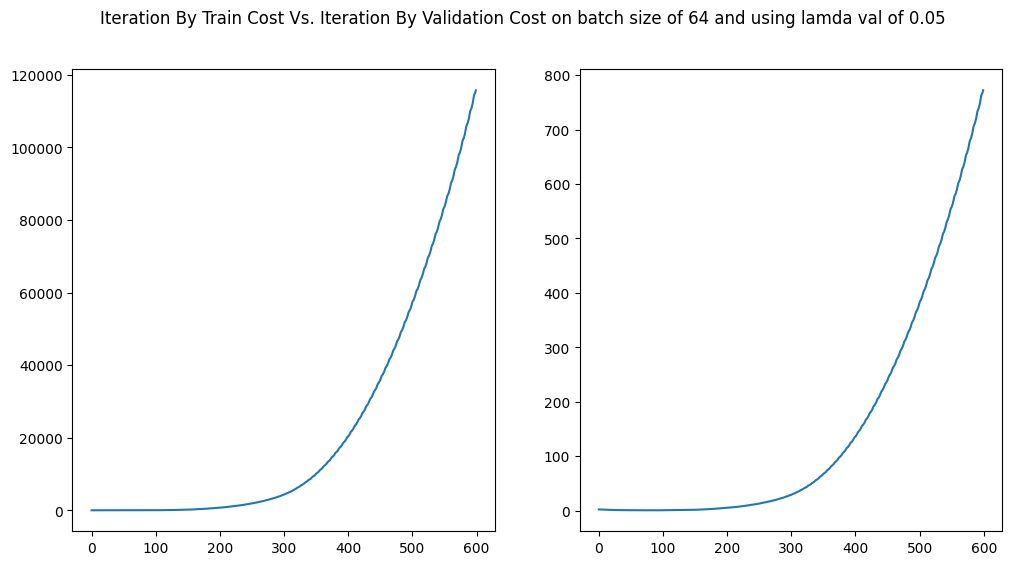

The cost on trianing step number: 100, the training loss: 2.27859
The cost on trianing step number: 200, the training loss: 2.20589
The cost on trianing step number: 300, the training loss: 2.17109
The cost on trianing step number: 400, the training loss: 2.10473
The cost on trianing step number: 500, the training loss: 1.96465
The cost on trianing step number: 600, the training loss: 1.93951
The cost on trianing step number: 700, the training loss: 1.87574
The cost on trianing step number: 800, the training loss: 1.7429
The cost on trianing step number: 900, the training loss: 1.71959
The cost on trianing step number: 1000, the training loss: 1.71727
The cost on trianing step number: 1100, the training loss: 1.60695
The cost on trianing step number: 1200, the training loss: 1.55523
The cost on trianing step number: 1300, the training loss: 1.59689
The cost on trianing step number: 1400, the training loss: 1.50735
The cost on trianing step number: 1500, the training loss: 1.43568
The c

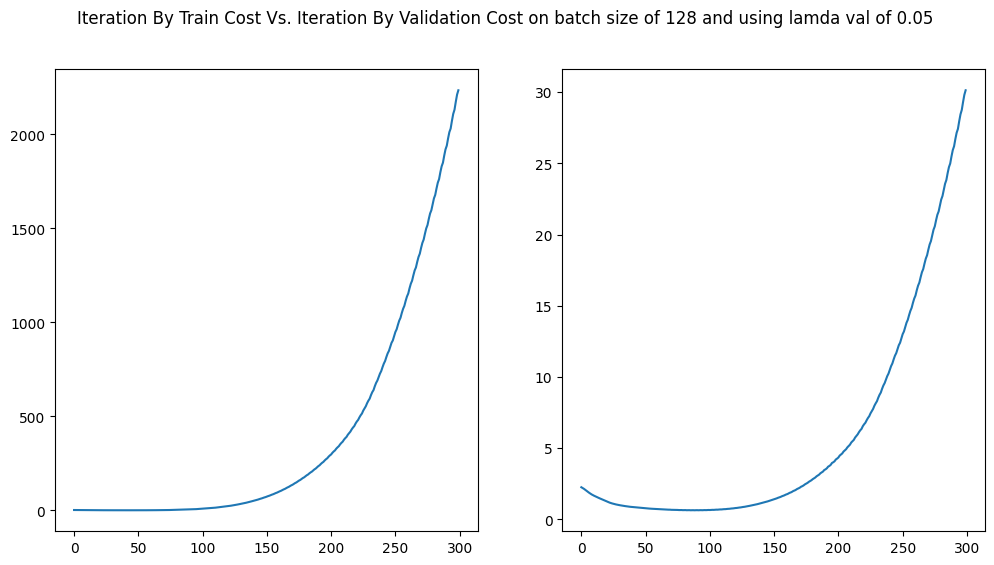

The cost on trianing step number: 100, the training loss: 2.28205
The cost on trianing step number: 200, the training loss: 2.21273
The cost on trianing step number: 300, the training loss: 2.15765
The cost on trianing step number: 400, the training loss: 2.06876
The cost on trianing step number: 500, the training loss: 2.01941
The cost on trianing step number: 600, the training loss: 1.93344
The cost on trianing step number: 700, the training loss: 1.82687
The cost on trianing step number: 800, the training loss: 1.82062
The cost on trianing step number: 900, the training loss: 1.72734
The cost on trianing step number: 1000, the training loss: 1.65009
The cost on trianing step number: 1100, the training loss: 1.68527
The cost on trianing step number: 1200, the training loss: 1.57103
The cost on trianing step number: 1300, the training loss: 1.52675
The cost on trianing step number: 1400, the training loss: 1.5648
The cost on trianing step number: 1500, the training loss: 1.44196
The c

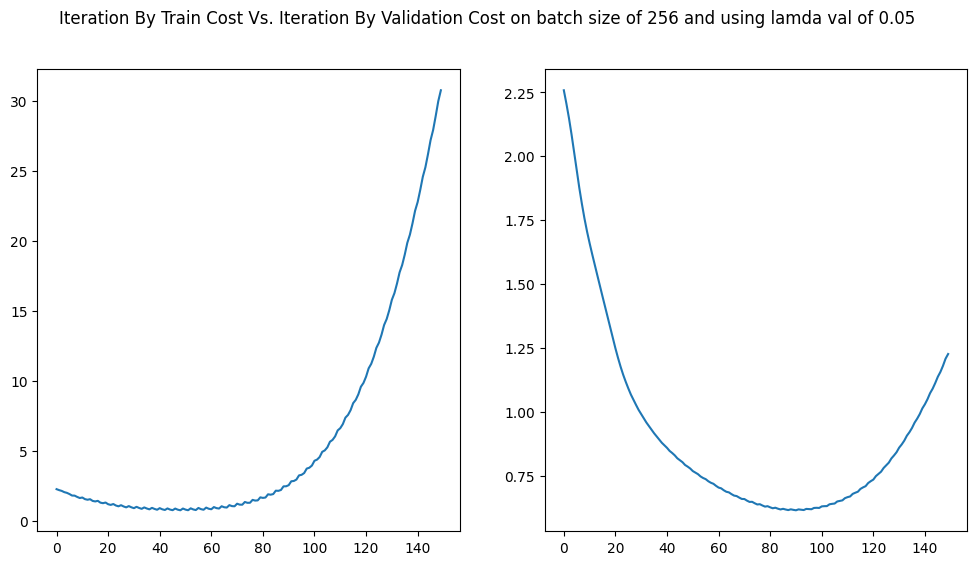

The cost on trianing step number: 100, the training loss: 2.25856
The cost on trianing step number: 200, the training loss: 2.20743
The cost on trianing step number: 300, the training loss: 2.15095
The cost on trianing step number: 400, the training loss: 2.09557
The cost on trianing step number: 500, the training loss: 1.99817
The cost on trianing step number: 600, the training loss: 1.93796
The cost on trianing step number: 700, the training loss: 1.89844
The cost on trianing step number: 800, the training loss: 1.77641
The cost on trianing step number: 900, the training loss: 1.73982
The cost on trianing step number: 1000, the training loss: 1.74154
The cost on trianing step number: 1100, the training loss: 1.61951
The cost on trianing step number: 1200, the training loss: 1.58417
The cost on trianing step number: 1300, the training loss: 1.61791
The cost on trianing step number: 1400, the training loss: 1.49735
The cost on trianing step number: 1500, the training loss: 1.45113
The 

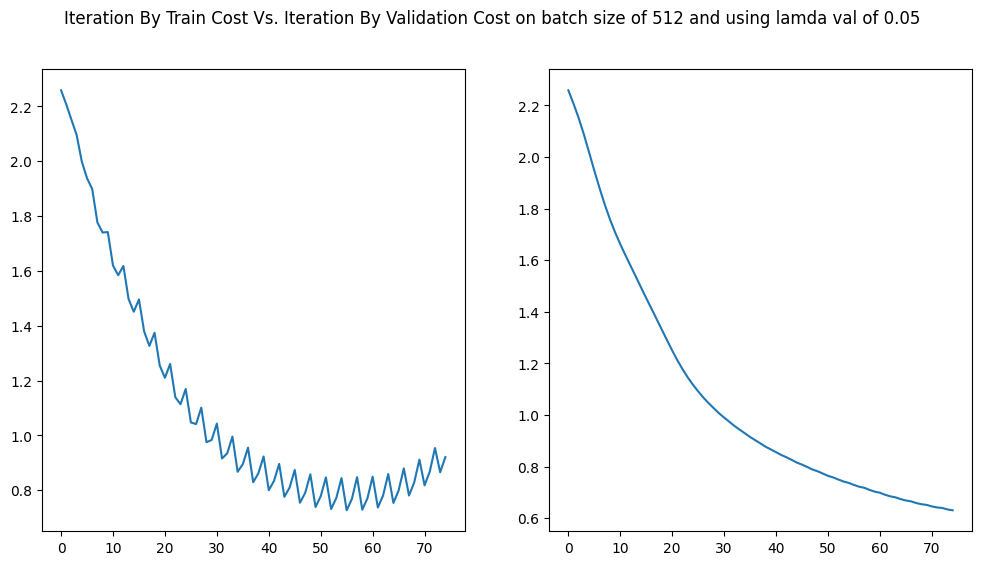

   Batch Size  Epoch Number  Iteration  Train Time in sec  Lamda  \
0        16.0          99.0   240001.0         358.786057   0.05   
1        32.0          99.0   120001.0         205.806100   0.05   
2        64.0          99.0    60001.0         113.257956   0.05   
3       128.0          99.0    30001.0          67.095102   0.05   
4       256.0          99.0    15001.0          45.200894   0.05   
5       512.0          99.0     7501.0          35.785083   0.05   

     Train Cost  Train Accuracy  Validation Cost  Validation Accuracy  \
0  7.640679e+07        0.859010    127345.154841             0.857187   
1  2.492274e+06        0.913385      8307.908510             0.900625   
2  1.157698e+05        0.925391       772.108136             0.906875   
3  2.234877e+03        0.915937        30.136424             0.898229   
4  3.076232e+01        0.903802         1.227017             0.891458   
5  9.208192e-01        0.853750         0.630801             0.850417   

   Test Acc

In [22]:
# Specify column names
columns = ['Batch Size', 'Epoch Number', 'Iteration', 'Train Time in sec', 'Lamda', 'Train Cost', 'Train Accuracy', 'Validation Cost', 'Validation Accuracy', 'Test Accuracy']
# Create an empty DataFrame with specified column names
df = pd.DataFrame(columns=columns)

batches = [16,32,64,128,256,512]
layers_dims = [784,20,7,5,10]
learning_rate = 0.009
num_iterations = 100
use_batchnorm = True
lamda = [0.05]
for l in lamda:
  for batch in batches:
    start_time = time.time()
    wb, costs, info = L_layer_model(train_images_tensor, train_labels_tensor, layers_dims=layers_dims, learning_rate=learning_rate, num_iterations=num_iterations, batch_size=batch, use_batchnorm=use_batchnorm, lamda=l)
    end_time = time.time()
    elapsed_time = end_time - start_time
    train_costs = info[0][-2]
    valid_costs = info[0][-1]
    train_acc = info[0][2]
    valid_acc = info[0][3]
    test_acc = Predict(test_images_tensor, test_labels_tensor, wb, use_batchnorm=use_batchnorm)
    print(f'Test Accuracy: {round(test_acc, 5)}')
    df_row = [batch, info[0][0], info[0][1], elapsed_time, l, train_costs[-1], train_acc, valid_costs[-1], valid_acc, round(test_acc, 5)]
    df.loc[len(df)] = df_row
    # # create plots for report
    x1= [i for i in range(len(train_costs))]
    x2= [i for i in range(len(valid_costs))]
    fig, (ax1, ax2) = plt.subplots(1, 2)
    # fig = plt.figure()

    fig.set_size_inches(12, 6)
    fig.suptitle(f'Iteration By Train Cost Vs. Iteration By Validation Cost on batch size of {batch} and using lamda val of {l}')
    ax1.plot(x1, train_costs)
    ax2.plot(x2, valid_costs)
    plt.show()

print(df)

**The network withoust using batch norm but with the use of l2 norm functionality (best model we got)**

In [23]:
tart_time = time.time()
wb, costs, info = L_layer_model(train_images_tensor, train_labels_tensor, layers_dims=layers_dims, learning_rate=learning_rate, num_iterations=num_iterations, batch_size=16, use_batchnorm=False, lamda=0.05)
end_time = time.time()

The cost on trianing step number: 100, the training loss: 2.36082
The cost on trianing step number: 200, the training loss: 2.35626
The cost on trianing step number: 300, the training loss: 2.35804
The cost on trianing step number: 400, the training loss: 2.36526
The cost on trianing step number: 500, the training loss: 2.3404
The cost on trianing step number: 600, the training loss: 2.35181
The cost on trianing step number: 700, the training loss: 2.35841
The cost on trianing step number: 800, the training loss: 2.35786
The cost on trianing step number: 900, the training loss: 2.34628
The cost on trianing step number: 1000, the training loss: 2.34124
The cost on trianing step number: 1100, the training loss: 2.34834
The cost on trianing step number: 1200, the training loss: 2.33656
The cost on trianing step number: 1300, the training loss: 2.36247
The cost on trianing step number: 1400, the training loss: 2.3523
The cost on trianing step number: 1500, the training loss: 2.32803
The co

**The network without using batch norm and l2 norm functionality (best model we got without using l2)**

In [24]:
start_time = time.time()
wb1, costs1, info1 = L_layer_model(train_images_tensor, train_labels_tensor, layers_dims=layers_dims, learning_rate=learning_rate, num_iterations=num_iterations, batch_size=16, use_batchnorm=False, lamda=0)
end_time = time.time()

The cost on trianing step number: 100, the training loss: 2.29117
The cost on trianing step number: 200, the training loss: 2.28701
The cost on trianing step number: 300, the training loss: 2.28914
The cost on trianing step number: 400, the training loss: 2.29671
The cost on trianing step number: 500, the training loss: 2.2723
The cost on trianing step number: 600, the training loss: 2.28396
The cost on trianing step number: 700, the training loss: 2.29099
The cost on trianing step number: 800, the training loss: 2.29071
The cost on trianing step number: 900, the training loss: 2.27926
The cost on trianing step number: 1000, the training loss: 2.2743
The cost on trianing step number: 1100, the training loss: 2.28076
The cost on trianing step number: 1200, the training loss: 2.26597
The cost on trianing step number: 1300, the training loss: 2.29655
The cost on trianing step number: 1400, the training loss: 2.28627
The cost on trianing step number: 1500, the training loss: 2.25232
The co

**Comparing the wiegths before and after l2 function**

In [25]:
for k in wb.keys():
  # Element-wise difference between two wieght matrices of the same layer
  difference_matrix = wb1[k] - wb[k]
  # Compute the sum to obtain a scalar value
  total_difference = torch.sum(difference_matrix).item()
  print(f"difference between {k} with and without using l2 function: {total_difference}")


difference between W1 with and without using l2 function: -3.431547229450173
difference between B1 with and without using l2 function: 0.2356940011064257
difference between W2 with and without using l2 function: 1.962054289636388
difference between B2 with and without using l2 function: -0.7003459205611355
difference between W3 with and without using l2 function: -0.7935287373372799
difference between B3 with and without using l2 function: -0.06697204202139485
difference between W4 with and without using l2 function: -0.32699345761896603
difference between B4 with and without using l2 function: -1.2168044349891716e-13
